# Inference of missing data in the predictor of a linear model

Whereas most examples focus on missing data in the outcome variable, in this example, I am exploring how to fill missing data in the predictor variable of a model for complete set of outcomes. The idea behind this is that there are forward models, which are difficult to invert, for example, when the outcomes are based on a (latent) random variable itself.

I would have liked to create a 2 step approach for building an inference machine that fills in gaps in the predictor variable after linearing about the functional relationship between pedictor and outcome, under complete data coverage. In a first step, that would be an inference model that creates posteriors for all model parameters and likelihoods for both outcome and predictors. The second step would then involve sampling from that posterior but at the same time inferring the likely values for the unobserved, i.e., missing predictor.

Currently, I'm stuck. So far, I think, I have gathered the following insights: 

- In "prediction" mode, i.e., when making posterior predictions for unobserved (i.e., missing) predictor value, I only recover the prior distributions despite the fact that `pm.sample_posterior_predictive(...)` (correctly) assumes and handles [Missing Value Imputatation](https://www.pymc.io/projects/examples/en/latest/howto/Missing_Data_Imputation.html) automatically. I think a proper MCMC sampling for those missing predictors is required.
- I get into trouble when we inject new data because the dimensions (or shapes) of some random variables are incorrect. Let's assume I infer a posterior for some mean values of $X$, `X_mu`. If it has an initial shape of `12` for 12 samples, it would throw an error if, in prediction mode, I want to infer 8 new values for `X_mu`.
- I wonder why this is straightforward if outcomes variables are missing. Obviously, you can re-run the model in *forward mode* and than infer new outcome posteriors. Why is the reverse not straightforward?

So, as one workaround (*workaround A*), I can run the MCMC for both steps at once and automatically infer unobserved predictors. Not ideal because for each new outcome (for which the predictor is unknown), I would have to re-run the whole MCMC procedure. 

Another workaround would be to approximate the posteriors from the first step and use them as prior in the prediction step (*workaround B*)

Sources:
- https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/#a-simple-use-of-posterior-predictive-sampling
- https://discourse.pymc.io/t/how-to-use-the-posterior-distribution-of-one-model-as-a-prior-distribution-for-another-model/13956
- https://github.com/pymc-devs/pymc-experimental/issues/330
- https://www.pymc.io/projects/experimental/en/latest/generated/pymc_experimental.utils.prior.prior_from_idata.html


# *Workaround A* - Combining Step 1 & 2

In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate synthetic data for the example
rng = np.random.default_rng(1234)
n_samples = 20 # number of samples
X_data_true = np.linspace(-2, 30, n_samples) # this is the true predictor
X_sigma = 1 # noise for observations of true predictor
Y_sigma = 0.1 # noise for observations of outcome
X_data = X_data_true + rng.normal(0, X_sigma, size=n_samples) # observations of true predictor (incl. noise)
c_true = 2.5 # some linear relationship (for illustrative purposes)
Y_data = c_true * X_data_true + rng.normal(0, Y_sigma, size=n_samples) # observations of outcome

# create train/text indices for masking
idx = range(n_samples)
idx_subset = rng.choice(n_samples,int(0.6*n_samples),replace=False)
print(f"{idx_subset = }")
idx_train = np.array([True if (i in idx_subset) else False for i in idx])
print(f"{idx_train = }")

X_test = X_data[~idx_train]

print(f"{X_data_true = }")
print(f"{X_data = }")
print(f"{Y_data = }")


# mask some predictor observations
X_data_masked = np.ma.masked_array(X_data,mask=~idx_train)
print(f"{X_data_masked = }")

# Step 1: Define the model
with pm.Model() as model_A:
    # Priors for parameters
    c = pm.Normal('c', mu=0, sigma=10)
    Y_sigma_ = pm.HalfNormal("Y_sigma", sigma=1)
    
    # prior for true means of predictor
    X_mu = pm.Normal('X_mu', mu=np.nanmean(X_data), sigma=np.std(X_data), shape=len(X_data))
    
    # Likelihood(s) for the observed data
    X_obs = pm.Normal('X_obs', mu=X_mu, sigma=X_sigma, observed=X_data_masked)
    Y_obs = pm.Normal('Y_obs', mu=c * X_obs, sigma=Y_sigma_, observed=Y_data)
    
    # Inference using MCMC
    trace_A = pm.sample(1000, return_inferencedata=True)

az.summary(trace_A, var_names=["~X_obs","~Y_obs"])

idx_subset = array([ 4, 12, 13, 19, 14, 18, 11, 17,  9,  7,  8,  6])
idx_train = array([False, False, False, False,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True])
X_data_true = array([-2.        , -0.31578947,  1.36842105,  3.05263158,  4.73684211,
        6.42105263,  8.10526316,  9.78947368, 11.47368421, 13.15789474,
       14.84210526, 16.52631579, 18.21052632, 19.89473684, 21.57894737,
       23.26315789, 24.94736842, 26.63157895, 28.31578947, 30.        ])
X_data = array([-3.60383681, -0.25168956,  2.10931235,  3.20525077,  5.600586  ,
        9.33415185,  6.6264398 , 10.73494666,  9.80754875, 13.50163932,
       14.32966155, 17.85007475, 17.35024612, 20.41423004, 20.31380365,
       21.10401888, 25.38210237, 28.36486827, 28.83592363, 28.99783421])
Y_data = array([-4.97316545, -0.71275621,  3.54017983,  7.51583787, 11.9117332 ,
       16.08776995, 20.25991639, 24.47500237, 28.61628553, 32.83268364,
   

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in X_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, Y_sigma, X_mu, X_obs_unobserved]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['Y_obs'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
X_mu[0],-1.664,1.413,-4.288,1.002,0.021,0.016,4695.0,2837.0,1.0
X_mu[1],0.012,1.382,-2.620,2.560,0.020,0.021,4876.0,3357.0,1.0
X_mu[2],1.662,1.437,-1.006,4.406,0.022,0.017,4305.0,3071.0,1.0
X_mu[3],3.286,1.423,0.659,6.040,0.022,0.016,4275.0,2987.0,1.0
X_mu[4],5.720,0.969,3.866,7.464,0.014,0.010,5023.0,3090.0,1.0
X_mu[5],6.630,1.420,3.895,9.195,0.022,0.016,4100.0,2754.0,1.0
X_mu[6],6.702,1.022,4.816,8.653,0.013,0.010,5949.0,2851.0,1.0
X_mu[7],10.779,0.973,8.899,12.527,0.012,0.009,6426.0,3275.0,1.0
X_mu[8],9.858,1.015,8.063,11.839,0.014,0.010,5481.0,2487.0,1.0
X_mu[9],13.510,0.995,11.612,15.303,0.013,0.009,6157.0,2942.0,1.0


In [2]:
with model_A:
    posterior_predictive_A = pm.sample_posterior_predictive(trace_A, var_names=["X_obs_unobserved", "Y_obs"])
az.summary(posterior_predictive_A, var_names=["X_obs_unobserved"])

Sampling: [X_obs_observed, X_obs_unobserved, Y_obs]


Output()

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/stats/stats.py:1353: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
X_obs_unobserved[0],-1.668,1.717,-5.118,1.376,0.026,0.019,4231.0,3647.0,1.0
X_obs_unobserved[1],0.012,1.695,-2.968,3.361,0.026,0.024,4398.0,3435.0,1.0
X_obs_unobserved[2],1.688,1.739,-1.506,4.882,0.026,0.020,4367.0,3602.0,1.0
X_obs_unobserved[3],3.279,1.723,-0.142,6.294,0.027,0.019,4211.0,3545.0,1.0
X_obs_unobserved[4],6.637,1.749,3.315,9.824,0.028,0.020,3835.0,3295.0,1.0
X_obs_unobserved[5],15.002,1.761,11.795,18.371,0.026,0.019,4463.0,3581.0,1.0
X_obs_unobserved[6],23.222,1.702,19.775,26.208,0.027,0.019,3902.0,3098.0,1.0
X_obs_unobserved[7],24.841,1.746,21.262,27.852,0.027,0.019,4177.0,3379.0,1.0


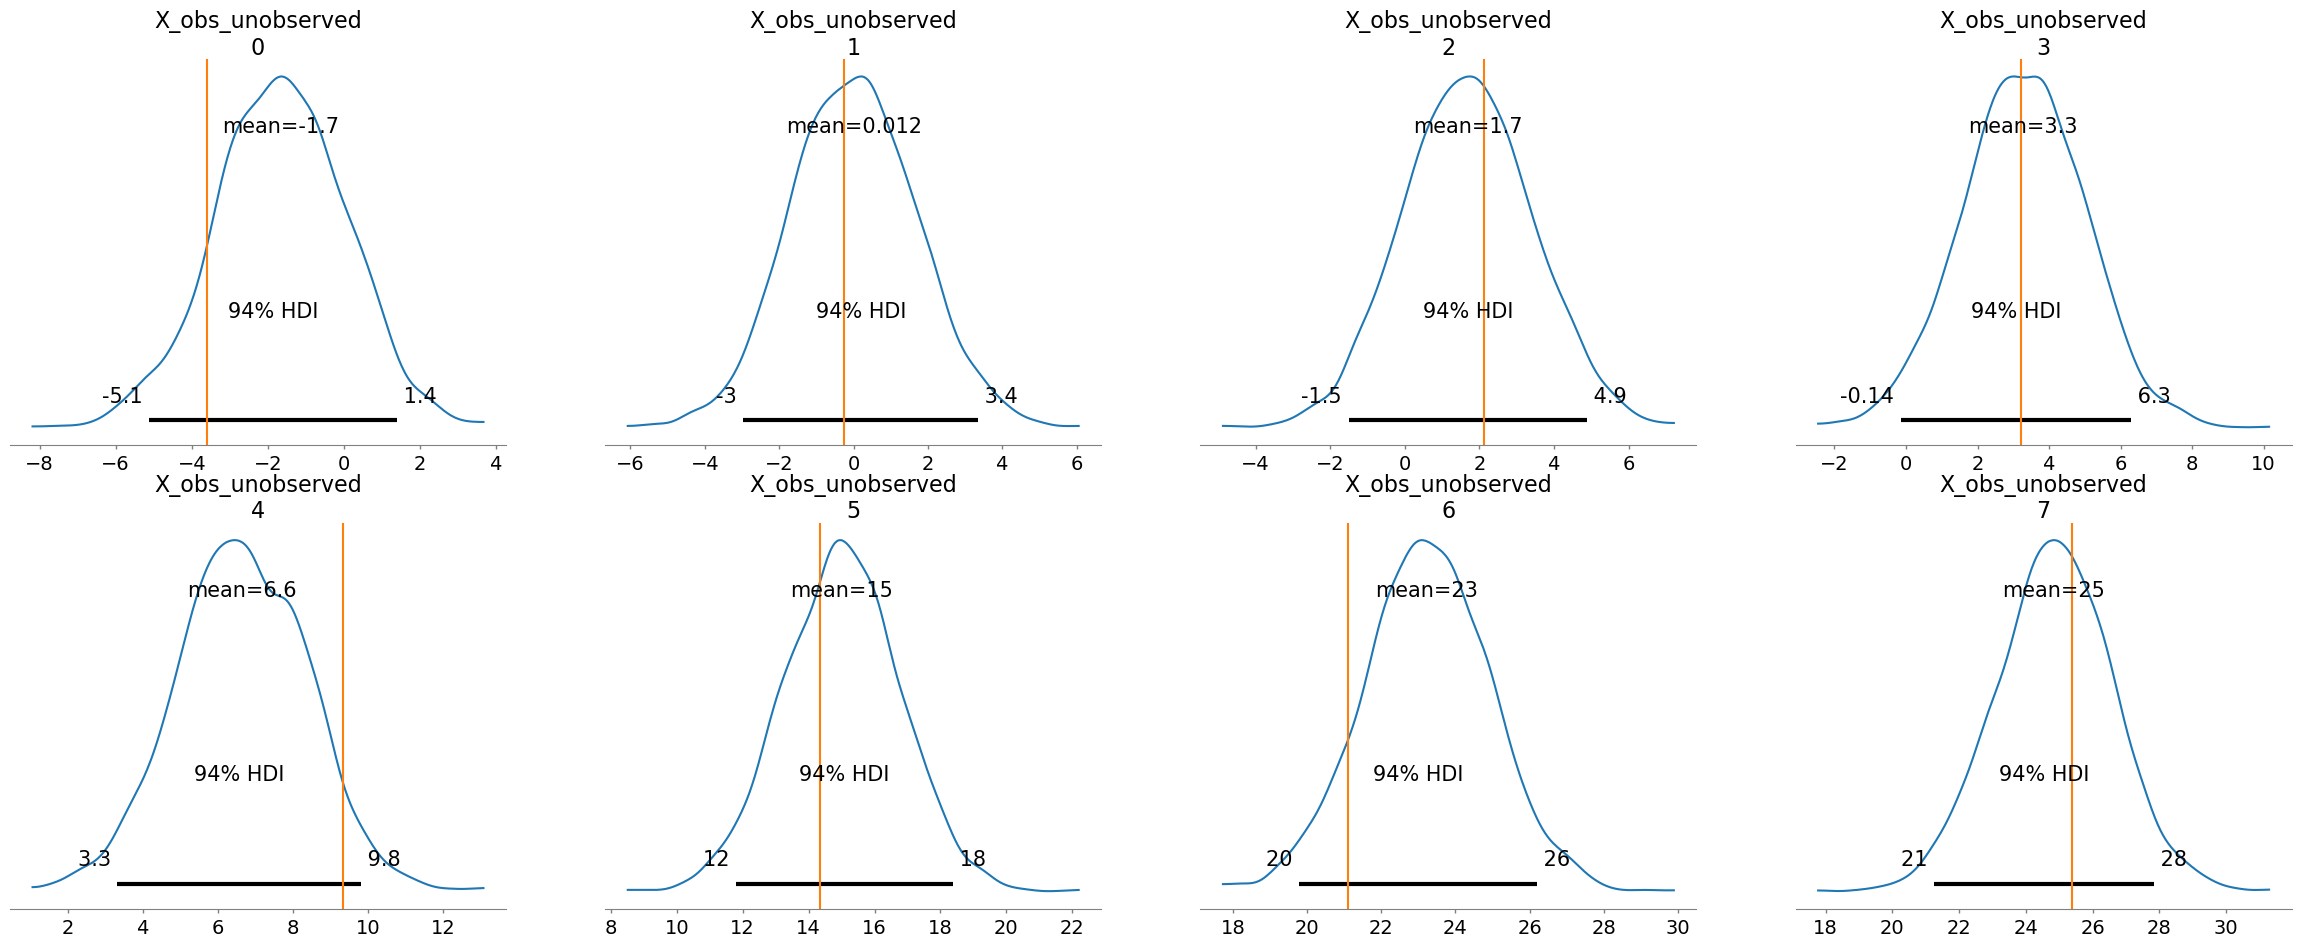

In [3]:

ax = az.plot_posterior(posterior_predictive_A, group="posterior_predictive", var_names=["X_obs_unobserved"])
ax = ax.flatten()
# for i in range(n_samples):
for i in range(len(X_test)):
    # ax[i].axvline(np.concatenate([X_train, X_test])[i])
    ax[i].axvline(X_test[i],c='C1')
    # print(f"{X_test[i] = }")

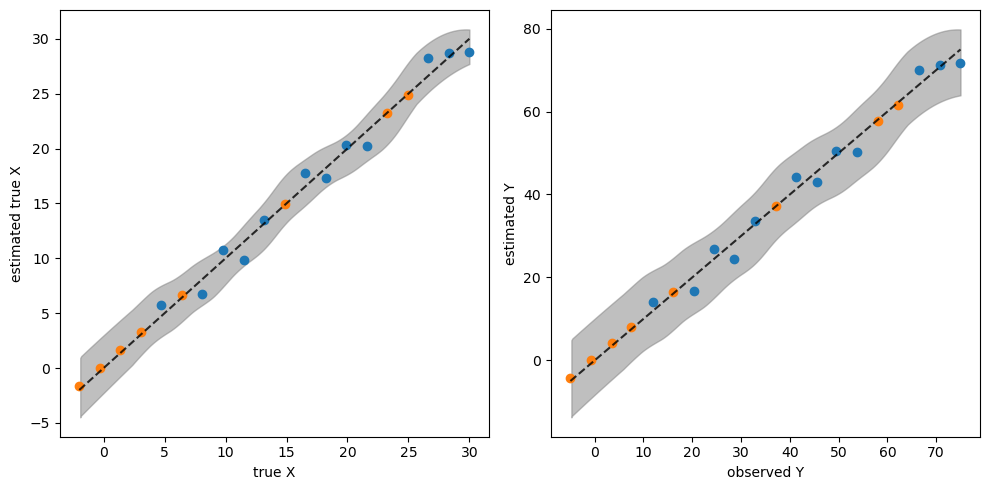

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

X_mu_p = trace_A.posterior.stack(samples=("chain", "draw")).mean("samples")["X_mu"]
Y_obs_p = posterior_predictive_A.posterior_predictive.stack(samples=("chain", "draw")).mean("samples")["Y_obs"]
ax[0].plot([X_data_true.min(), X_data_true.max()], [X_data_true.min(), X_data_true.max()], 'k--', alpha=0.8)
az.plot_hdi(X_data_true, trace_A.posterior["X_mu"],color='gray',ax=ax[0])
ax[0].scatter(X_data_true[idx_train], X_mu_p[idx_train])
ax[0].scatter(X_data_true[~idx_train], X_mu_p[~idx_train])
ax[0].set_xlabel("true X")
ax[0].set_ylabel("estimated true X")
# ax[0].set_aspect("equal")

ax[1].plot([Y_data.min(), Y_data.max()], [Y_data.min(), Y_data.max()], 'k--', alpha=0.8)
az.plot_hdi(Y_data, posterior_predictive_A.posterior_predictive["Y_obs"],color='gray',ax=ax[1])
ax[1].scatter(Y_data[idx_train], Y_obs_p[idx_train])
ax[1].scatter(Y_data[~idx_train], Y_obs_p[~idx_train])
ax[1].set_xlabel("observed Y")
ax[1].set_ylabel("estimated Y")
# ax[1].set_aspect("equal")

fig.tight_layout()

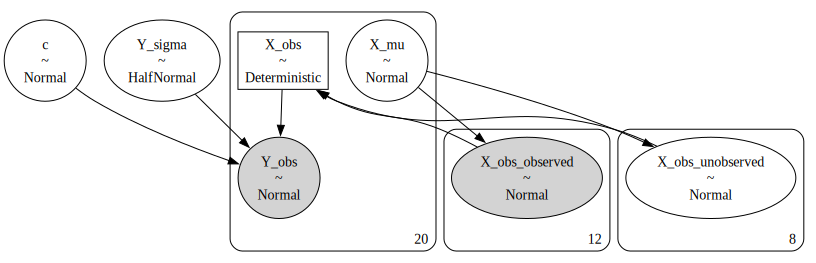

In [5]:
pm.model_to_graphviz(model_A)

# *Workaround B* - Approximating the posterior

In [6]:
X_train = X_data[idx_train]
Y_train = Y_data[idx_train]

# Step 1: Define the model
with pm.Model() as model_B1:
    # Priors for parameters
    c = pm.Normal('c', mu=0, sigma=10)
    Y_sigma_ = pm.HalfNormal("Y_sigma", sigma=1)
    
    # prior for true means of predictor
    X_mu = pm.Normal('X_mu', mu=np.mean(X_train), sigma=np.std(X_train), shape=len(X_train))
    
    # Likelihood(s) for the observed data
    X_obs = pm.Normal('X_obs', mu=X_mu, sigma=X_sigma, observed=X_train)
    Y_obs = pm.Normal('Y_obs', mu=c * X_obs, sigma=Y_sigma_, observed=Y_train)
    
    # Inference using MCMC
    trace_B1 = pm.sample(1000, return_inferencedata=True)

az.summary(trace_B1, var_names=["~X_obs","~Y_obs"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, Y_sigma, X_mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['X_obs', 'Y_obs'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
X_mu[0],5.755,1.010,3.906,7.649,0.012,0.009,6632.0,2996.0,1.0
X_mu[1],6.790,0.983,4.958,8.579,0.011,0.008,7365.0,3037.0,1.0
X_mu[2],10.843,0.988,8.913,12.640,0.010,0.007,9025.0,2765.0,1.0
X_mu[3],9.909,1.000,8.097,11.830,0.013,0.009,6346.0,3424.0,1.0
X_mu[4],13.560,0.989,11.644,15.315,0.012,0.008,7266.0,2845.0,1.0
X_mu[5],17.844,0.996,16.053,19.782,0.011,0.008,8343.0,3117.0,1.0
X_mu[6],17.333,1.003,15.474,19.215,0.012,0.009,6932.0,2648.0,1.0
X_mu[7],20.381,1.007,18.574,22.274,0.013,0.009,6174.0,2698.0,1.0
X_mu[8],20.266,1.005,18.420,22.206,0.011,0.008,8177.0,3313.0,1.0
X_mu[9],28.199,0.975,26.416,30.067,0.012,0.009,6236.0,3240.0,1.0


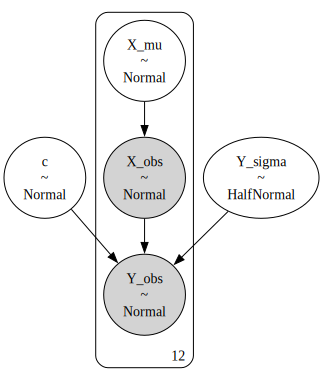

In [7]:
pm.model_to_graphviz(model_B1)

args = (2.485018118227582, 0.03890711421626181)
args = (0.1935080939941991, 0.5672673777597664, 1.8944257822127506)


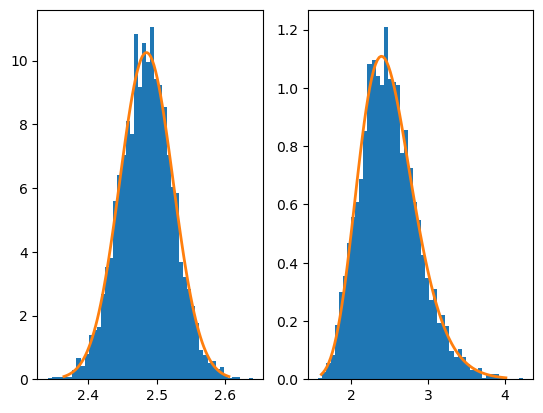

In [8]:
from scipy.stats import norm, lognorm

fig, ax = plt.subplots(1,2)

dist = {"c": norm, "Y_sigma": lognorm}

args_dict = {}

for i, k in enumerate(['c','Y_sigma']):
    vals = trace_B1.posterior[k].values.flatten()
    args = dist[k].fit(vals)
    ax[i].hist(vals,density=True, bins=50)
    x = np.linspace(dist[k].ppf(0.001,*args), dist[k].ppf(0.999,*args), 100)
    ax[i].plot(x, dist[k].pdf(x,*args) , lw=2)
    print(f"{args = }")
    args_dict[k] = args

In [9]:
# Step 2: Infer unobserrved predictor values
# lognorm.pdf(y, s) / scale with y = (x - loc) / scale
Y_test = Y_data[~idx_train]
with pm.Model() as model_B2:
    # Priors for parameters
    c = pm.Normal('c', mu=args_dict["c"][0], sigma=args_dict["c"][1])
    Y_sigma_ = pm.LogNormal("Y_sigma", mu=args_dict["Y_sigma"][1], sigma=args_dict["Y_sigma"][0])*args_dict["Y_sigma"][2]
    
    # prior for true means of predictor
    X_mu = pm.Normal('X_mu', mu=np.mean(X_train), sigma=np.std(X_train), shape=len(X_test))
    
    # Likelihood(s) for the observed data
    X_obs = pm.Normal('X_obs', mu=X_mu, sigma=X_sigma, observed=[np.nan]*len(X_test))
    Y_obs = pm.Normal('Y_obs', mu=c * X_obs, sigma=Y_sigma_, observed=Y_test)
    
    # Inference using MCMC
    trace_B2 = pm.sample(1000, return_inferencedata=True)

az.summary(trace_B2)

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in X_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, Y_sigma, X_mu, X_obs_unobserved]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
X_mu[0],-1.121,1.657,-4.221,1.953,0.021,0.022,6154.0,3070.0,1.0
X_mu[1],0.491,1.741,-2.843,3.704,0.022,0.029,6453.0,2826.0,1.0
X_mu[2],2.154,1.743,-1.114,5.391,0.022,0.023,6371.0,3037.0,1.0
X_mu[3],3.603,1.706,0.445,6.850,0.023,0.018,5599.0,3030.0,1.0
X_mu[4],6.966,1.667,3.986,10.283,0.022,0.016,5906.0,3053.0,1.0
X_mu[5],15.126,1.682,12.112,18.460,0.021,0.015,6374.0,3190.0,1.0
X_mu[6],23.113,1.720,19.886,26.351,0.022,0.016,6153.0,2675.0,1.0
X_mu[7],24.742,1.735,21.462,28.026,0.024,0.017,5227.0,3010.0,1.0
X_obs[0],-1.433,1.376,-4.048,1.071,0.018,0.016,5797.0,3033.0,1.0
X_obs[1],0.228,1.464,-2.448,3.032,0.019,0.024,5911.0,2744.0,1.0


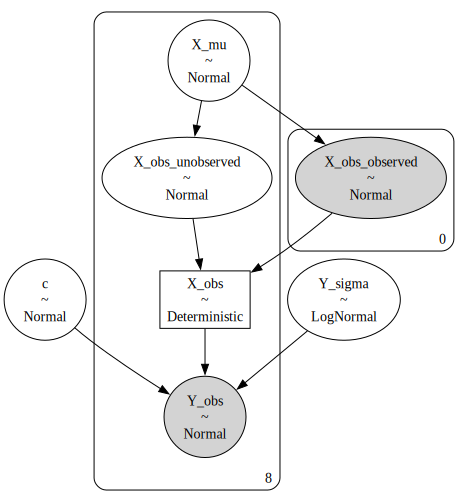

In [14]:
pm.model_to_graphviz(model_B2)

In [11]:
with model_B2:
    posterior_predictive_B2 = pm.sample_posterior_predictive(trace_B2, var_names=["X_obs_unobserved", "Y_obs"])

az.summary(posterior_predictive_B2)

Sampling: [X_obs_observed, X_obs_unobserved, Y_obs]


Output()

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/stats/stats.py:1353: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
X_obs_unobserved[0],-1.095,1.969,-4.843,2.537,0.028,0.025,5078.0,3442.0,1.0
X_obs_unobserved[1],0.461,2.017,-3.248,4.304,0.027,0.030,5421.0,3113.0,1.0
X_obs_unobserved[2],2.132,2.013,-1.719,5.819,0.027,0.025,5593.0,3301.0,1.0
X_obs_unobserved[3],3.604,1.987,-0.184,7.381,0.027,0.021,5307.0,3202.0,1.0
X_obs_unobserved[4],6.980,1.933,3.446,10.724,0.027,0.019,5181.0,3445.0,1.0
X_obs_unobserved[5],15.128,1.956,11.358,18.666,0.027,0.019,5361.0,3484.0,1.0
X_obs_unobserved[6],23.135,1.985,19.515,27.019,0.027,0.019,5511.0,3383.0,1.0
X_obs_unobserved[7],24.717,1.983,21.099,28.453,0.028,0.020,5048.0,3196.0,1.0
Y_obs[0],-2.682,6.095,-14.048,8.881,0.091,0.074,4445.0,3728.0,1.0
Y_obs[1],1.234,6.081,-10.232,12.291,0.086,0.082,4977.0,3456.0,1.0


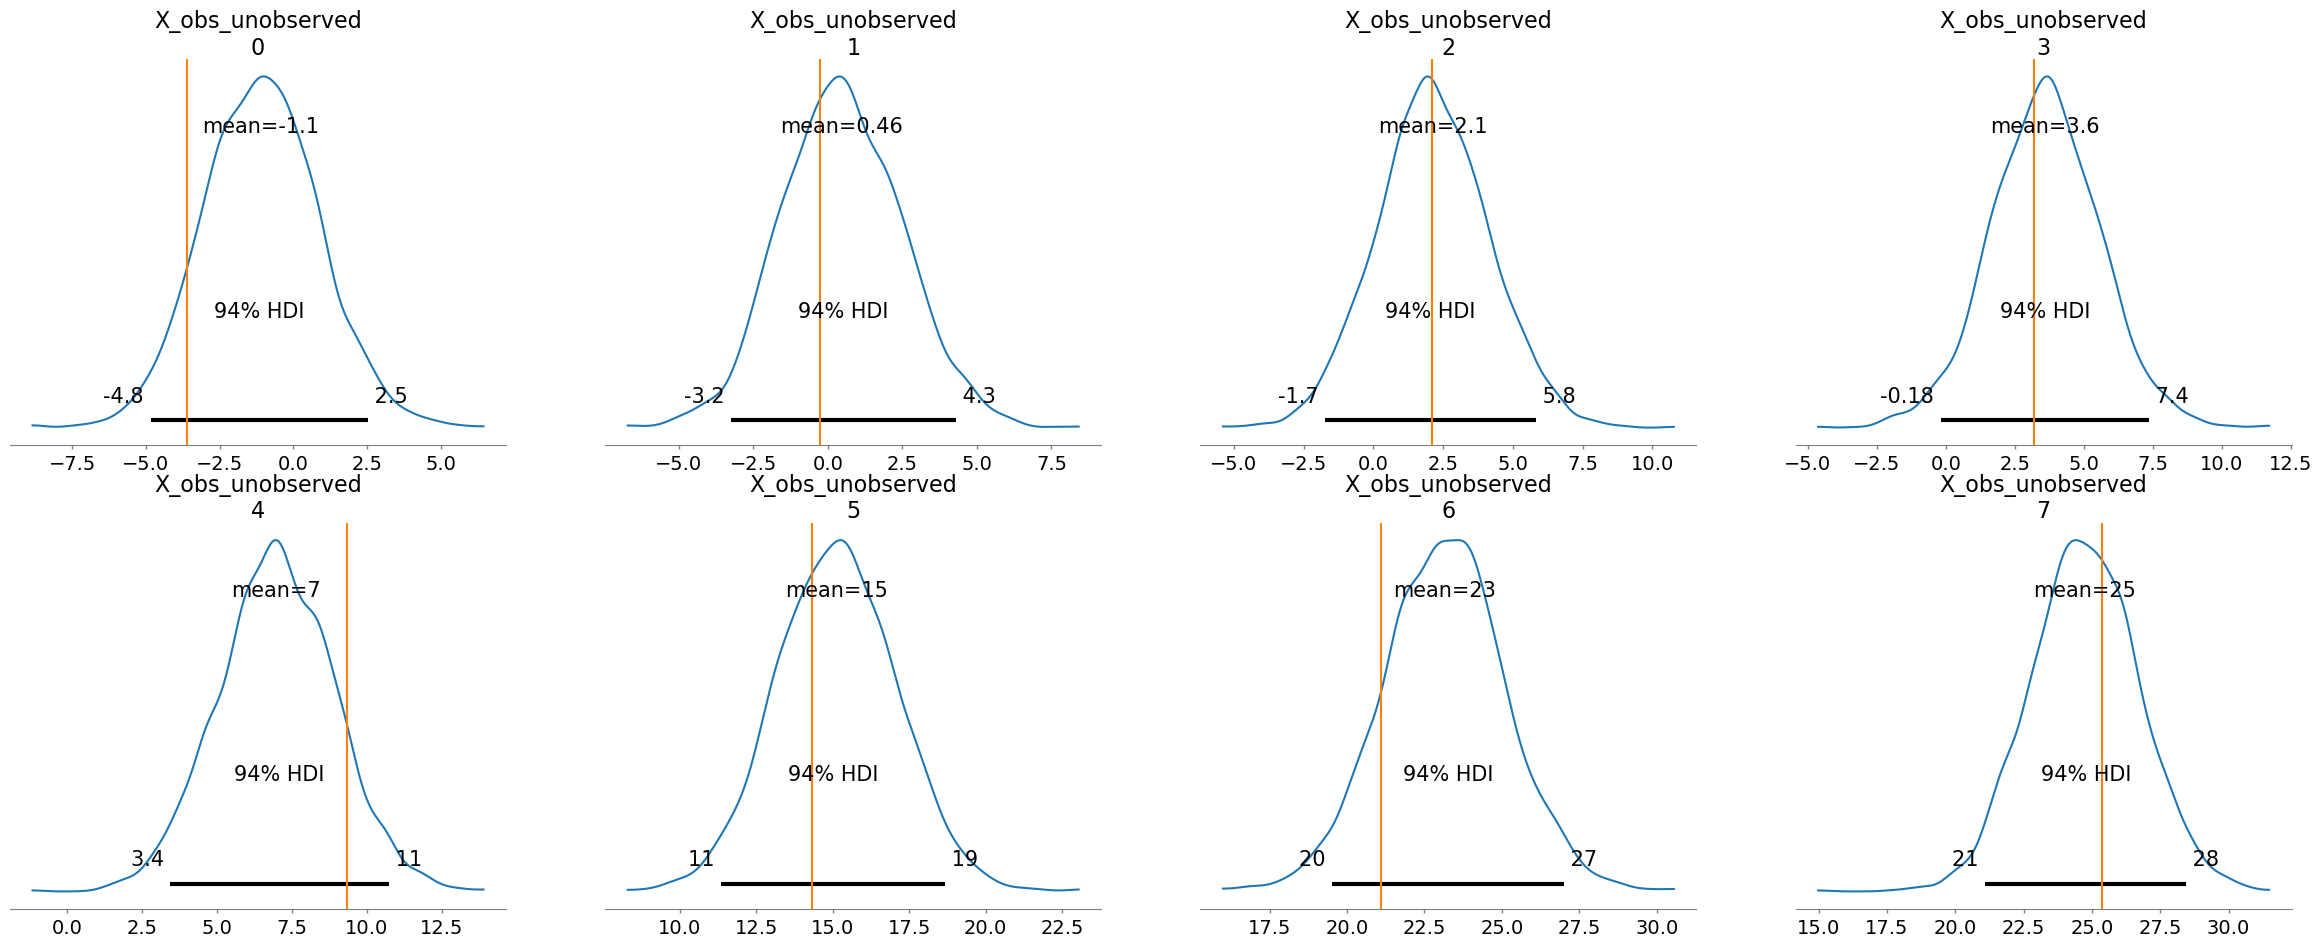

In [12]:

ax = az.plot_posterior(posterior_predictive_B2, group="posterior_predictive", var_names=["X_obs_unobserved"])
ax = ax.flatten()
# for i in range(n_samples):
for i in range(len(X_test)):
    # ax[i].axvline(np.concatenate([X_train, X_test])[i])
    ax[i].axvline(X_test[i],c='C1')
    # print(f"{X_test[i] = }")

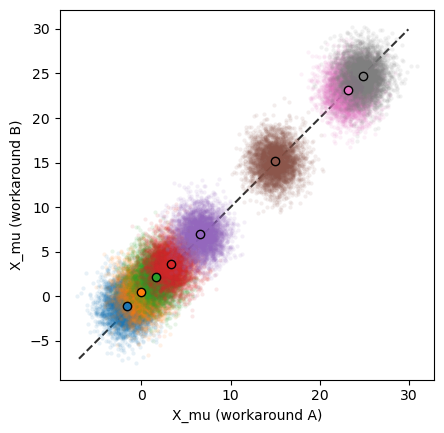

In [13]:
fig, ax = plt.subplots(1,1)
X_mu_A = trace_A.posterior.stack(samples=("chain", "draw"))["X_mu"][~idx_train,:].values
X_mu_B2 = trace_B2.posterior.stack(samples=("chain", "draw"))["X_mu"].values

ax.plot([X_data_true[~idx_train].min()-5, X_data_true[~idx_train].max()+5], [X_data_true[~idx_train].min()-5, X_data_true[~idx_train].max()+5], 'k--', alpha=0.8)
for i in range(len(X_test)):
    l, = ax.plot(X_mu_A[i,:],X_mu_B2[i,:],'.',mew=0,alpha=0.1)
    ax.plot(X_mu_A[i,:].mean(),X_mu_B2[i,:].mean(),'o',color=l.get_color(),mec='k', zorder=5)

ax.set_xlabel("X_mu (workaround A)")
ax.set_ylabel("X_mu (workaround B)")

ax.set_aspect("equal")

# Summary (so far...)

It looks (last plot) like both workarounds lead to the same outcome. However, I assume that this is also in part because of the simplicity of this (linear) model.